In [1]:
! pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 744M/745M [00:17<00:00, 34.0MB/s]
100% 745M/745M [00:17<00:00, 45.7MB/s]


In [2]:
! unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [3]:
import shutil

In [4]:
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Viral Pneumonia', ignore_errors=True)

In [5]:
shutil.rmtree('/content/COVID-19_Radiography_Dataset/Lung_Opacity', ignore_errors=True)
! rm /content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx
! rm /content/COVID-19_Radiography_Dataset/README.md.txt

Delete the file 
! rm /content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx
manually

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
from keras.preprocessing.image import load_img

In [7]:
import os
old_file = os.path.join("/content/COVID-19_Radiography_Dataset", "Viral Pneumonia.metadata.xlsx")
new_file = os.path.join("/content/COVID-19_Radiography_Dataset", "ViralPneumonia.metadata.xlsx")
os.rename(old_file, new_file)

In [8]:
!rm -rf /content/COVID-19_Radiography_Dataset/ViralPneumonia.metadata.xlsx

In [ ]:
data = []
label = []

for class_name in os.listdir("/content/COVID-19_Radiography_Dataset"):
    for path in os.listdir("/content/COVID-19_Radiography_Dataset/"+class_name):
        if class_name=="COVID":
            label.append(0)
        else:
            label.append(1)
        data.append(os.path.join("/content/COVID-19_Radiography_Dataset",class_name,path))
print(data[0],label[0])

/content/COVID-19_Radiography_Dataset/COVID/COVID-3084.png 0


In [ ]:
df = pd.DataFrame()
df['images']=data
df['label']=label
df = df.sample(frac=1).reset_index(drop=True)
#frac = 1 ensures that it will return all rows
df.head()

,images,label
0,/content/COVID-19_Radiography_Dataset/Normal/N...,1
1,/content/COVID-19_Radiography_Dataset/Normal/N...,1
2,/content/COVID-19_Radiography_Dataset/COVID/CO...,0
3,/content/COVID-19_Radiography_Dataset/Normal/N...,1
4,/content/COVID-19_Radiography_Dataset/COVID/CO...,0


In [ ]:
df['label'] = df['label'].astype('str')

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_generator = ImageDataGenerator(rescale=1./255)

train_iterator=train_generator.flow_from_dataframe(train,
                              x_col='images',
                              y_col='label',
                              target_size=(128,128),
                              batch_size=512,
                              class_mode='binary')

val_iterator = val_generator.flow_from_dataframe(train,
                              x_col='images',
                              y_col='label',
                              target_size=(128,128),
                              batch_size=512,
                              class_mode='binary')

Found 11046 validated image filenames belonging to 2 classes.
Found 11046 validated image filenames belonging to 2 classes.


In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout

model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))


model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.50))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [ ]:
history = model.fit(train_iterator, epochs=20, validation_data=val_iterator)

Epoch 1/20
22/22 [==============================] - 103s 5s/step - loss: 0.8443 - accuracy: 0.7075 - val_loss: 0.6099 - val_accuracy: 0.7363
Epoch 2/20
22/22 [==============================] - 97s 4s/step - loss: 0.5739 - accuracy: 0.7363 - val_loss: 0.5883 - val_accuracy: 0.7363
Epoch 3/20
22/22 [==============================] - 97s 4s/step - loss: 0.5254 - accuracy: 0.7402 - val_loss: 0.5058 - val_accuracy: 0.7475
Epoch 4/20
22/22 [==============================] - 96s 4s/step - loss: 0.4970 - accuracy: 0.7526 - val_loss: 0.4829 - val_accuracy: 0.7748
Epoch 5/20
22/22 [==============================] - 96s 4s/step - loss: 0.4804 - accuracy: 0.7715 - val_loss: 0.4645 - val_accuracy: 0.7755
Epoch 6/20
22/22 [==============================] - 96s 4s/step - loss: 0.4640 - accuracy: 0.7839 - val_loss: 0.4368 - val_accuracy: 0.8034
Epoch 7/20
22/22 [==============================] - 96s 4s/step - loss: 0.4465 - accuracy: 0.7940 - val_loss: 0.4145 - val_accuracy: 0.8206
Epoch 8/20
22/22 [=

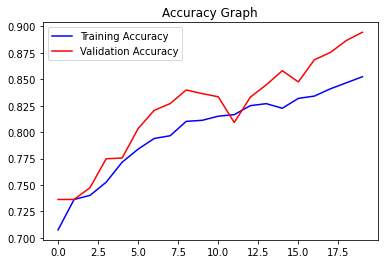

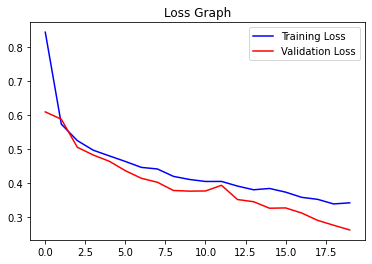

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model.save('//content/COVID-19_Radiography_Dataset/covid_detect.h5')

In [ ]:
! pip install streamlit


In [ ]:
class_names = ['Covid','Normal']

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

abvchhk


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/COVID-19_Radiography_Dataset/covid_detect.h5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Covid Detection
         """
         )

file = st.file_uploader("Please upload an X-Ray scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)